流程是01是對所有的text使用beto-sentiment-analysis模型抽取得到768維度的向量表示，然後由於這個維度有點太大，使用了PCA對其進行降維，把維度降低到128維。

In [46]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from torch import nn
import pandas as pd
import lightgbm as lgb
from tqdm import tqdm
from sklearn.decomposition import PCA
import numpy as np
from numba import jit

**測試測試**
匯入

In [47]:
tokenizer = AutoTokenizer.from_pretrained("../pretrained/")
model = AutoModelForSequenceClassification.from_pretrained("../pretrained/") # BYR p52 モデルのロード

emb_model = nn.Sequential(*list(model.children())[:-2])

print(model.config) # p52 自己看資料用

BertConfig {
  "_name_or_path": "../pretrained/",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "NEG",
    "1": "NEU",
    "2": "POS"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "NEG": 0,
    "NEU": 1,
    "POS": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "transformers_version": "4.29.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 31006
}



【導入Pretrained model（beto-sentiment-analysis）】
https://huggingface.co/finiteautomata/beto-sentiment-analysis

【GitHub】
https://github.com/pysentimiento/pysentimiento

【論文】
https://arxiv.org/abs/2106.09462

【Tokenizer】
tokenize提供了“對Python 代碼使用的”詞彙掃描器。掃描器可以給Python 代碼打上標記後返回，你可以看到每一個詞或者字符是什麼類型的。掃描器甚至將註釋也單獨標記，這樣某些需要對代碼進行特定風格展示的地方就很方便了。

https://docs.python.org/zh-tw/3/library/tokenize.html

【Auto Class】
在許多情況下，你想使用的架構可以從你提供給from_pretrained()方法的預訓練模型的名稱或路徑中猜到。 AutoClasses在這里為你做這項工作，這樣你就能自動檢索到相關的模型，並給出預訓練的權重/配置/詞彙的名稱/路徑。

[Auto Classes (Huggingface)](https://huggingface.co/docs/transformers/model_doc/auto)

【nn.Sequential】A sequential container. Modules will be added to it in the order they are passed in the constructor. Alternatively, an ordered dict of modules can also be passed in. 一个有顺序的容器。模块将按照构造函数中传递的顺序被添加到其中。另外，也可以传入一个有序的模块口令。

現在我們來研究一下nn.Sequential，不同於nn.ModuleList，它已經實現了內部的forward 函數，而且裡面的模塊必須是按照順序進行排列的，所以我們必須確保前一個模塊的輸出大小和下一個模塊的輸入大小是一致的


[詳解PyTorch中的ModuleList和Sequential](https://zhuanlan.zhihu.com/p/75206669)
   [nn.Sequential講解](https://blog.csdn.net/dss_dssssd/article/details/82980222)
   
   [PyTorch 中的ModuleList 和Sequential: 區別和使用場景](https://zhuanlan.zhihu.com/p/64990232)
   
【model.children】children()與modules()都是返回網絡模型裡的組成元素，但是children()返回的是最外層的元素，modules()返回的是所有的元素，包括不同級別的子元素。

[pytorch Module裡的children()與modules()的區別](https://blog.csdn.net/LXX516/article/details/79016980)

list.index(x[, start[, end]])
回傳 list 中第一個值等於 x 的項目之索引值（從零開始的索引）。若 list 中無此項目，則丟出 ValueError 錯誤。

引數 start 和 end 的定義跟在 slice 表示法中相同，搜尋的動作被這兩個引數限定在 list 中特定的子序列。但要注意的是，回傳的索引值是從 list 的開頭開始算，而不是從 start 開始算。

print的東西 p53

"num_hidden_layers": 12,

"hidden_size": 768,

"max_position_embeddings": 512

In [48]:
def gen_emb(text):
    enc_code = tokenizer.encode_plus(text,max_length=64) 
    #BYR p59 #文章符號化
    emb_out = emb_model(torch.Tensor(enc_code['input_ids']).unsqueeze(0).long())['pooler_output'] 
    #BYR p73
    return emb_out.squeeze(0).cpu().detach().numpy()

把輸入的text轉換成token，
下面那個是輸入token，是對bert模型的輸出做了pooling的結果，如果不太清楚bert的原理的話，你可以簡單的認為那個就是把輸入的token轉換成了一個768維度的向量

[huggingface Tokenizer の tokenize, encode, encode_plus などの違い](https://zenn.dev/hellorusk/articles/7fd588cae5b173)

encode_plus: 
先に述べた encode に加え、言語モデルの入力として必要な他の id を一緒に出力します。BERT であれば token type id と attention mask を一緒に出力します。

torch.Tensor:
入力にラベルを加える。torch.Tensor（data） == torch.FloatTensor(data)

unsqueeze(0)

In [49]:
train_df = pd.read_csv('../data/train/behaviors.tsv',sep='\t',names=['Impression_ID','User_ID','Time','History','Impressions'])
train_text = pd.read_csv('../data/train/news.tsv',encoding='utf-8',error_bad_lines=False,sep='\t',names=['News_ID','Category','SubCategory','Title','Abstract','URL','Title_Entities','Abstract_Entites'])

# 輸出訓練數據的總數量
print(f"train_df 的數據總數量為：{train_df.shape[0]}")
print(f"train_text 的數據總數量為：{train_text.shape[0]}")
print(type(train_df))

/tmp/ipykernel_42710/2359400868.py:2: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  train_text = pd.read_csv('../data/train/news.tsv',encoding='utf-8',error_bad_lines=False,sep='\t',names=['News_ID','Category','SubCategory','Title','Abstract','URL','Title_Entities','Abstract_Entites'])


train_df 的數據總數量為：156965
train_text 的數據總數量為：51282
<class 'pandas.core.frame.DataFrame'>


In [50]:
test_df = pd.read_csv('../data/test/behaviors.tsv',sep='\t',names=['Impression_ID','User_ID','Time','History','Impressions'])
test_text = pd.read_csv('../data/test/news.tsv',encoding='utf-8',error_bad_lines=False,sep='\t',names=['News_ID','Category','SubCategory','Title','Abstract','URL','Title_Entities','Abstract_Entites'])

/tmp/ipykernel_42710/2332082990.py:2: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  test_text = pd.read_csv('../data/test/news.tsv',encoding='utf-8',error_bad_lines=False,sep='\t',names=['News_ID','Category','SubCategory','Title','Abstract','URL','Title_Entities','Abstract_Entites'])


#### 讀取dataset（train/ test）

train_df 資料匯入

df：Pandas DataFrame物件

In [51]:
train_text = train_text.dropna()
test_text = test_text.dropna()
train_text

,News_ID,Category,SubCategory,Title,Abstract,URL,Title_Entities,Abstract_Entites
0,N55528,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the...",https://assets.msn.com/labs/mind/AAGH0ET.html,"[{""Label"": ""Prince Philip, Duke of Edinburgh"",...",[]
1,N19639,health,weightloss,50 Worst Habits For Belly Fat,These seemingly harmless habits are holding yo...,https://assets.msn.com/labs/mind/AAB19MK.html,"[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik...","[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik..."
2,N61837,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...,https://assets.msn.com/labs/mind/AAJgNsz.html,[],"[{""Label"": ""Ukraine"", ""Type"": ""G"", ""WikidataId..."
3,N53526,health,voices,I Was An NBA Wife. Here's How It Affected My M...,"I felt like I was a fraud, and being an NBA wi...",https://assets.msn.com/labs/mind/AACk2N6.html,[],"[{""Label"": ""National Basketball Association"", ..."
4,N38324,health,medical,"How to Get Rid of Skin Tags, According to a De...","They seem harmless, but there's a very good re...",https://assets.msn.com/labs/mind/AAAKEkt.html,"[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI...","[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI..."
...,...,...,...,...,...,...,...,...
51275,N17258,news,newsscienceandtechnology,Realme takes chunk of India mobile market as S...,Over 400 percent more phones shipped year-on-year,https://assets.msn.com/labs/mind/BBWzDfx.html,"[{""Label"": ""Realme"", ""Type"": ""N"", ""WikidataId""...",[]
51276,N23858,sports,golf,Young Northeast Florida fans flock to U.S. wom...,When the U.S. women's national soccer team arr...,https://assets.msn.com/labs/mind/BBWzQB8.html,"[{""Label"": ""First Coast"", ""Type"": ""G"", ""Wikida...","[{""Label"": ""United States women's national soc..."
51277,N16909,weather,weathertopstories,"Adapting, Learning And Soul Searching: Reflect...",Woolsey Fire Anniversary: A community is forev...,https://assets.msn.com/labs/mind/BBWzQJK.html,"[{""Label"": ""Woolsey Fire"", ""Type"": ""N"", ""Wikid...","[{""Label"": ""Woolsey Fire"", ""Type"": ""N"", ""Wikid..."
51279,N7482,sports,more_sports,St. Dominic soccer player tries to kick cancer...,"Sometimes, what happens on the sidelines can b...",https://assets.msn.com/labs/mind/BBWzQnK.html,[],[]


Pandas dropna()方法允許用戶以不同的方式分析和刪除具有Null值的行/列。 

參數： axis:axis接受行/列的int或字符串值。 對於整數，輸入可以為0或1；對於字符串，輸入可以為“索引”或“列”。

In [123]:
# df = ([train_text,test_text], axis=0).reset_index(drop=True)
df = pd.concat([train_text, test_text], axis=0).reset_index(drop=True)


[reset_index( ) 用法及代碼示例](https://vimsky.com/zh-tw/examples/usage/python-pandas-dataframe-reset_index.html)

In [124]:
def convert2emb(df):
    text_emb = np.zeros((len(df),768))
    for i in tqdm(range(len(df))):
        text_emb[i,:] = gen_emb(df['Abstract'].iloc[i])
    return text_emb

numpy.zeros：創建0矩陣。

Tqdm：一個快速，可擴展的Python進度條，可以在Python 長循環中添加一個進度提示信息，用戶只需要封裝任意的迭代器 tqdm(iterator)。

iloc函數：通過行號來取行數據（如取第二行的數據）

# Eigenvalue criterion

In [125]:
df

,News_ID,Category,SubCategory,Title,Abstract,URL,Title_Entities,Abstract_Entites
0,N55528,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the...",https://assets.msn.com/labs/mind/AAGH0ET.html,"[{""Label"": ""Prince Philip, Duke of Edinburgh"",...",[]
1,N19639,health,weightloss,50 Worst Habits For Belly Fat,These seemingly harmless habits are holding yo...,https://assets.msn.com/labs/mind/AAB19MK.html,"[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik...","[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik..."
2,N61837,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...,https://assets.msn.com/labs/mind/AAJgNsz.html,[],"[{""Label"": ""Ukraine"", ""Type"": ""G"", ""WikidataId..."
3,N53526,health,voices,I Was An NBA Wife. Here's How It Affected My M...,"I felt like I was a fraud, and being an NBA wi...",https://assets.msn.com/labs/mind/AACk2N6.html,[],"[{""Label"": ""National Basketball Association"", ..."
4,N38324,health,medical,"How to Get Rid of Skin Tags, According to a De...","They seem harmless, but there's a very good re...",https://assets.msn.com/labs/mind/AAAKEkt.html,"[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI...","[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI..."
...,...,...,...,...,...,...,...,...
89000,N42491,movies,movies-celebrity,Roman Polanski Denies Rape Allegation by Valen...,Responding to French actress Valentine Monnier...,https://assets.msn.com/labs/mind/BBWysN3.html,"[{""Label"": ""Roman Polanski"", ""Type"": ""P"", ""Wik...","[{""Label"": ""Roman Polanski"", ""Type"": ""P"", ""Wik..."
89001,N13097,movies,movienews,Marvel's Kevin Feige Breaks Silence on Scorses...,In his first public comments about the debate ...,https://assets.msn.com/labs/mind/BBWywC9.html,"[{""Label"": ""Martin Scorsese"", ""Type"": ""P"", ""Wi...","[{""Label"": ""Marvel Cinematic Universe"", ""Type""..."
89002,N63550,lifestyle,lifestyleroyals,Why Kate & Meghan Were on Different Balconies ...,There's no scandal here. It's all about the or...,https://assets.msn.com/labs/mind/BBWyynu.html,"[{""Label"": ""Meghan, Duchess of Sussex"", ""Type""...",[]
89003,N30345,entertainment,entertainment-celebrity,See the stars at the 2019 Baby2Baby gala,Stars like Chrissy Teigen and Kate Hudson supp...,https://assets.msn.com/labs/mind/BBWyz7N.html,[],"[{""Label"": ""Kate Hudson"", ""Type"": ""P"", ""Wikida..."


# Scree Plot

In [115]:
text_emb = convert2emb(df)

  0%|                                     | 167/89005 [00:08<1:15:34, 19.59it/s]


KeyboardInterrupt: 

In [126]:
text_emb.shape

(89005, 768)

The number of components needed to explain 90% of the variance is: 95


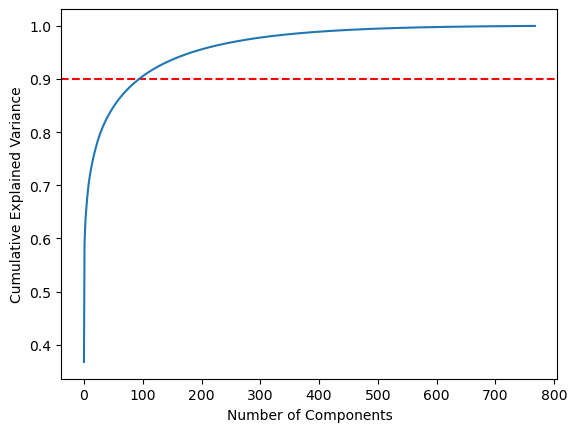

In [127]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
import matplotlib.pyplot as plt


pca = PCA().fit(text_emb)
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)
# 找到累積解釋方差超過或等於95%的第一個位置
# n_components_95 = np.where(cumulative_explained_variance >= 0.95)[0][0] + 1  # 加1是因為索引從0開始
n_components_90 = np.where(cumulative_explained_variance >= 0.9)[0][0] + 1  # 加1是因為索引從0開始

# print(f"The number of components needed to explain 95% of the variance is: {n_components_95}")
# plt.axhline (y=0.95, color='r', linestyle= '--')
print(f"The number of components needed to explain 90% of the variance is: {n_components_90}")
plt.axhline (y=0.9, color='r', linestyle= '--')
plt.plot(cumulative_explained_variance)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()


Eigenvalues:  [2.75691835e+01 1.67335420e+01 2.23567524e+00 1.55373796e+00
 1.13502827e+00 1.01917265e+00 8.88447030e-01 7.80754414e-01
 7.62482985e-01 6.06608249e-01 5.30944721e-01 4.98120148e-01
 4.67304403e-01 4.30307516e-01 4.08978414e-01 4.02834634e-01
 3.84536626e-01 3.53617143e-01 3.47141475e-01 3.25045021e-01
 3.14674955e-01 3.07918877e-01 2.93162462e-01 2.87389762e-01
 2.67798897e-01 2.59938391e-01 2.55242805e-01 2.33591983e-01
 2.27044408e-01 2.14496104e-01 2.10556392e-01 2.05667023e-01
 2.03809597e-01 1.92234700e-01 1.89637997e-01 1.83453360e-01
 1.77845080e-01 1.72500201e-01 1.68977031e-01 1.60687205e-01
 1.58732857e-01 1.54858172e-01 1.54029034e-01 1.46857839e-01
 1.44917444e-01 1.40973360e-01 1.39674890e-01 1.36991605e-01
 1.34403988e-01 1.32430385e-01 1.28006200e-01 1.26468479e-01
 1.22877626e-01 1.20463342e-01 1.20082817e-01 1.19003490e-01
 1.14364313e-01 1.11544222e-01 1.10905496e-01 1.09539702e-01
 1.06438810e-01 1.03868386e-01 1.02658797e-01 1.01052063e-01
 1.0028435

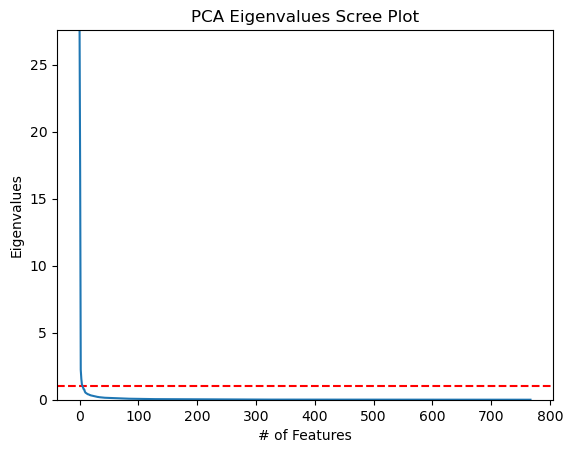

In [128]:
# Applying the Kaiser’s Eigenvalue Criterion to choose the number of principal components, 
# performing PCA transformation, and evaluating the resulting PCs using a linear correlation matrix.
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


# pca = PCA(n_components=128)
# pca.fit(text_emb)
# pca_text_emb = pca.transform(text_emb)
pca = PCA().fit(text_emb)
# pca.fit(text_emb)

# 获取特征值
eigenvalues = pca.explained_variance_
print('Eigenvalues: ',eigenvalues)

# 找到特征值大于1的特征值的数量
components_to_keep = sum(eigenvalues > 1)
print('Components to keep: ', components_to_keep)

# 打印建议保留的主成分数量
print(f"Number of principal components to keep based on Kaiser's Criterion: {components_to_keep}")
plt.ylabel("Eigenvalues")
plt.xlabel("# of Features") 
plt.title('PCA Eigenvalues Scree Plot')
plt.ylim(0, max(eigenvalues))
plt.style.context ('seaborn-whitegrid') 
plt.axhline (y=1, color='r', linestyle= '--')
plt.plot(eigenvalues) 
plt.show()
# pca_text_emb = pca.transform(text_emb)

In [130]:
# 1. 使用PCA進行轉換
# n_components = n_components_95  # 假設您想要的主成份數量
# n_components = n_components_90  # 假設您想要的主成份數量
n_components = 6
pca = PCA(n_components=n_components)
text_emb_pca = pca.fit_transform(text_emb)

# # 2. 將PCA的結果轉換為DataFrame
# text_emb_pca_df = pd.DataFrame(text_emb_pca)

# # 3. 計算這個DataFrame的相關矩陣
# correlation_matrix = text_emb_pca_df.corr()

# # 4. 使用Seaborn或Matplotlib繪製熱圖
# plt.figure(figsize=(10,10))
# sns.heatmap(correlation_matrix, vmin=-1, vmax=1, cmap='coolwarm', annot=False)
# plt.show()
# #     PCA Transformation:
# #         Now, perform PCA again specifying the chosen number of components and transform your data.
# pca = PCA(n_components=10)
# pca.fit(text_emb)
# # transformed_data = pca.transform(text_emb)
# # After transforming the data, assess the correlation between the chosen principal components.
# # Creating a DataFrame from the transformed data
# df_transformed = pd.DataFrame(pca)

# # Calculating the correlation matrix


# # 將numpy array轉換為pandas DataFrame
# # text_emb_df = pd.DataFrame(text_emb)
# correlation_matrix = df_transformed.corr()

# # Display correlation matrix
# # print(correlation_matrix)
# # 可视化相关矩阵
# # 繪製熱圖
# plt.figure(figsize=(10,10))  # 調整圖形大小
# sns.heatmap(correlation_matrix, vmin=-1, vmax=1, cmap='coolwarm', annot=False) 
# plt.show()


In [131]:
for i in range(n_components):
    df[f'text_emb_{i}'] = text_emb_pca[:,i]

利用PCA進行降維

In [132]:
df

,News_ID,Category,SubCategory,Title,Abstract,URL,Title_Entities,Abstract_Entites,text_emb_0,text_emb_1,text_emb_2,text_emb_3,text_emb_4,text_emb_5
0,N55528,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the...",https://assets.msn.com/labs/mind/AAGH0ET.html,"[{""Label"": ""Prince Philip, Duke of Edinburgh"",...",[],1.268577,2.702366,-2.571218,-2.407196,-0.700220,-0.377095
1,N19639,health,weightloss,50 Worst Habits For Belly Fat,These seemingly harmless habits are holding yo...,https://assets.msn.com/labs/mind/AAB19MK.html,"[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik...","[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik...",-1.911136,6.631266,-1.333309,-1.529063,-0.074567,-1.427971
2,N61837,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...,https://assets.msn.com/labs/mind/AAJgNsz.html,[],"[{""Label"": ""Ukraine"", ""Type"": ""G"", ""WikidataId...",-3.284393,-2.907786,0.309812,0.171927,-1.261185,-0.971639
3,N53526,health,voices,I Was An NBA Wife. Here's How It Affected My M...,"I felt like I was a fraud, and being an NBA wi...",https://assets.msn.com/labs/mind/AACk2N6.html,[],"[{""Label"": ""National Basketball Association"", ...",12.571485,1.249968,1.816219,-1.502210,-0.222737,0.077337
4,N38324,health,medical,"How to Get Rid of Skin Tags, According to a De...","They seem harmless, but there's a very good re...",https://assets.msn.com/labs/mind/AAAKEkt.html,"[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI...","[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI...",-4.031466,-3.446858,0.610785,-1.118334,-1.648499,-0.580772
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89000,N42491,movies,movies-celebrity,Roman Polanski Denies Rape Allegation by Valen...,Responding to French actress Valentine Monnier...,https://assets.msn.com/labs/mind/BBWysN3.html,"[{""Label"": ""Roman Polanski"", ""Type"": ""P"", ""Wik...","[{""Label"": ""Roman Polanski"", ""Type"": ""P"", ""Wik...",7.460862,-1.658075,0.268753,-0.351681,0.147267,-1.126289
89001,N13097,movies,movienews,Marvel's Kevin Feige Breaks Silence on Scorses...,In his first public comments about the debate ...,https://assets.msn.com/labs/mind/BBWywC9.html,"[{""Label"": ""Martin Scorsese"", ""Type"": ""P"", ""Wi...","[{""Label"": ""Marvel Cinematic Universe"", ""Type""...",0.255995,-2.567230,-1.898305,-1.099857,0.106213,-0.534990
89002,N63550,lifestyle,lifestyleroyals,Why Kate & Meghan Were on Different Balconies ...,There's no scandal here. It's all about the or...,https://assets.msn.com/labs/mind/BBWyynu.html,"[{""Label"": ""Meghan, Duchess of Sussex"", ""Type""...",[],-5.104100,-2.785293,0.688448,-2.214475,-0.753047,-1.174730
89003,N30345,entertainment,entertainment-celebrity,See the stars at the 2019 Baby2Baby gala,Stars like Chrissy Teigen and Kate Hudson supp...,https://assets.msn.com/labs/mind/BBWyz7N.html,[],"[{""Label"": ""Kate Hudson"", ""Type"": ""P"", ""Wikida...",-7.200874,1.269013,1.297500,1.021023,1.073530,2.059526


In [133]:
df.to_csv('../data/text_embeded_6.csv',index=False)

儲存結果至text_emb.csv